In [1]:
# imports
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt

import math
import torch
import torchvr
from torchvr.samplers import UniformSampler, Mabs, Vrb, AdaSample

from utils import Problem, fit

In [2]:
# Generates the data
N = 100
d = 10

# generates the features
# the gradient norms are set to be proportional to lognormal random variables
norms = (torch.randn(N)).exp()
X = torch.randn(N, d)
X /= X.pow(2).sum(dim=1).unsqueeze(1)
X *= norms.unsqueeze(1)

# generates the targets from a logistic model
true_weight = torch.randn(d)
y = torch.bernoulli(torch.sigmoid(X @ true_weight)).float()

In [3]:
# defines the model
class Logistic_regression(torch.nn.Module):
    
    def __init__(self, d):
        super().__init__()
        self.lin = torchvr.layers.IsLinear(d, 1, bias=False)
    
    def forward(self, input, weights_grads=None):
        output = self.lin(input, weights_grads)
        return torch.sigmoid(output.squeeze(1))

# initializes the model and the loss function
model = Logistic_regression(d)
loss_func = torch.nn.BCELoss(reduction='sum')
reg = 1.0

# saves starting point
start = deepcopy(model.state_dict())

problem = Problem(X, y, model, start, loss_func, reg)

100%|██████████| 100/100 [00:00<00:00, 2186.46it/s]


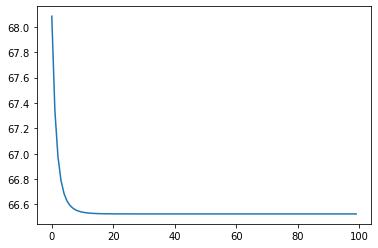

In [4]:
# finds the optimal function value
# defines parameters of the problem
N, d = X.shape
L = 0.25 * torch.symeig(X.t() @ X)[0][-1] + reg
mu = reg

# requires grad not is_grad
model.lin.requires_is_grad = False
for p in model.parameters():
    p.requires_grad_()    

# initializes the optimizer
opt = torch.optim.SGD(model.parameters(), lr=1/L, weight_decay=reg)

# training loop
epochs = 100
losses = torch.zeros(epochs)
model.load_state_dict(start)
for epoch in tqdm(range(epochs)):
    output = model(X)
    loss = loss_func(output, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    with torch.no_grad():
        emp_loss = loss_func(model(X), y)
        reg_loss = 0
        for p in model.parameters():
            reg_loss += reg * p.pow(2).sum()/2
        losses[epoch] = (emp_loss + reg_loss).item()


# requires grad not is_grad
for p in model.parameters():
    p.requires_grad = False
model.lin.requires_is_grad = True

# plot the losses
plt.plot(losses)
loss_star = losses[-1].item()

## batch size = 1

In [15]:
# general parameters
epochs = 100
runs = 10
batch_size = 1

L = 0.25 * torch.symeig(X.t() @ X)[0][-1] + reg
L_max = 0.25 * max(X.pow(2).sum(dim=1)) + reg/N
mu = reg
G =  max(X.pow(2).sum(dim=1).sqrt())
lr = batch_size/(2*N*L_max)

### constant step-size

In [16]:
samplers = dict()
samplers["Uniform"] = UniformSampler(X, model.parameters(), batch_size)
samplers["MABS"] = Mabs(X, model.parameters(), batch_size,G=G, T=epochs*len(X))
samplers["VRB"] = Vrb(X, model.parameters(), batch_size, G=G, T=epochs*len(X))
samplers["AdaSample"] = AdaSample(X, model.parameters(),batch_size, p_min=1/(5*N))

In [17]:
results = dict()
for name, sampler in samplers.items():
    results[name] = fit(problem, sampler, lr, runs=runs,  epochs=epochs)

100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


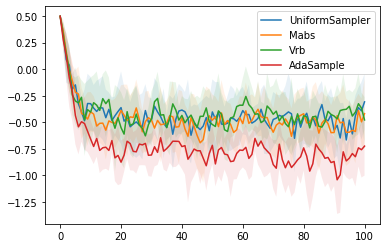

In [18]:
plt.plot()
for result in results.values():
    result.all_results(loss_star)
    result.plt_results("subopts")
plt.legend()

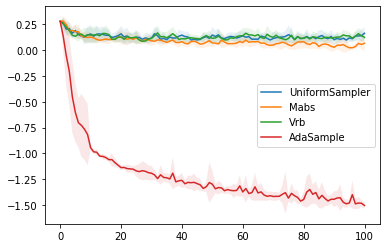

In [19]:
plt.plot()
for alg, result in results.items():
    result.all_results(loss_star)
    result.plt_results("per_step_relative_regrets")
plt.legend()

### decreasing step-size

In [20]:
schedule_lr = lambda num_iter : batch_size/(2*N*L_max + batch_size * mu * num_iter)

In [21]:
samplers = dict()
samplers["Uniform"] = UniformSampler(X, model.parameters(), batch_size)
samplers["MABS"] = Mabs(X, model.parameters(), batch_size,G=G, T=epochs*len(X))
samplers["VRB"] = Vrb(X, model.parameters(), batch_size, G=G, T=epochs*len(X))
samplers["AdaSample"] = AdaSample(X, model.parameters(),batch_size)

In [22]:
results = dict()
for name, sampler in samplers.items():
    results[name] = fit(problem, sampler, lr, schedule_lr, runs=runs, epochs=epochs)

100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


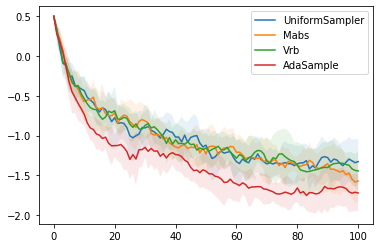

In [23]:
plt.plot()
for result in results.values():
    result.all_results(loss_star)
    result.plt_results("subopts")
plt.legend()

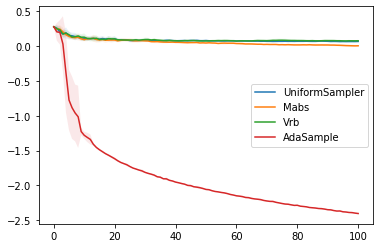

In [24]:
plt.plot()
for result in results.values():
    result.all_results(loss_star)
    result.plt_results("per_step_relative_regrets")
plt.legend()